In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

In [4]:
import os
base_model = 'roberta-base'
dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)
def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [5]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


In [6]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [7]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']
# Examine class distribution to ensure balance
label_counts = pd.Series(train_dataset['labels']).value_counts()
print(f"Label distribution in training set:\n{label_counts}")

Label distribution in training set:
0    29855
2    29847
1    29842
3    29816
Name: count, dtype: int64


In [8]:
# PEFT Config
peft_config = LoraConfig(
    r=4,
    lora_alpha=8,
    lora_dropout=0.05,
    bias = 'none',
    target_modules = ['query'],
    task_type="SEQ_CLS",
)

In [9]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

In [10]:
def Calculate_training_parameters(model):
    training_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            training_params += param.numel()
    return training_params, all_params

In [11]:
training_params, all_params = Calculate_training_parameters(peft_model)
print(f"Training parameters: {training_params:,}")
print(f"All parameters: {all_params:,}")
print('PEFT Model')
peft_model.print_trainable_parameters()

Training parameters: 667,396
All parameters: 125,316,104
PEFT Model
trainable params: 667,396 || all params: 125,316,104 || trainable%: 0.5326


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Calculate accuracy and other metrics
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [14]:

import transformers
TrainingArguments = transformers.TrainingArguments


output_dir = "results_1"
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy='steps',
    eval_steps=100,
    logging_steps=200,
    learning_rate=2.0e-4,
    num_train_epochs=5,
    max_steps=-1,

    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    dataloader_num_workers=8,
    optim="adamw_torch",
    report_to="none",
)

In [15]:
training_params, all_params = Calculate_training_parameters(peft_model)
print(f"Training parameters: {training_params:,}")
print(f"All parameters: {all_params:,}")

Training parameters: 667,396
All parameters: 125,316,104


In [16]:
def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )


In [17]:
# Start Training
peft_lora_finetuning_trainer = get_trainer(peft_model)

# Train the model and capture results
result = peft_lora_finetuning_trainer.train()

# Display training results
print(f"Training completed with loss: {result.metrics['train_loss']:.4f}")
print(f"Training time: {result.metrics['train_runtime']:.2f} seconds")

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,No log,0.366125,0.881250,0.881670,0.881250,0.880932
200,0.695000,0.300756,0.910937,0.910930,0.910937,0.910725
300,0.695000,0.298530,0.904687,0.906498,0.904687,0.904478
400,0.315700,0.286416,0.912500,0.913269,0.912500,0.912165
500,0.315700,0.289939,0.903125,0.903938,0.903125,0.902808
600,0.288600,0.280056,0.904687,0.905282,0.904687,0.904494
700,0.288600,0.271989,0.906250,0.906413,0.906250,0.906042
800,0.266000,0.267609,0.910937,0.911858,0.910937,0.910729
900,0.266000,0.269617,0.912500,0.912766,0.912500,0.912373
1000,0.251500,0.259009,0.909375,0.909128,0.909375,0.909169


Training completed with loss: 0.2215
Training time: 1328.07 seconds


In [18]:
# Inference function
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    model.to(device)
    model.eval()

    with torch.no_grad():
        output = model(**inputs)

    # Get prediction and convert to probabilities
    logits = output.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    prediction = logits.argmax(dim=-1).item()
    confidence = probabilities[0][prediction].item()

    print(f'\nClass: {prediction}, Label: {id2label[prediction]}, Confidence: {confidence:.4f}')
    print(f'Text: {text}')

    # Show all class probabilities
    print("\nProbabilities for all classes:")
    for i, label in id2label.items():
        print(f"{label}: {probabilities[0][i].item():.4f}")

    return id2label[prediction]

In [19]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


Class: 1, Label: Sports, Confidence: 0.8916
Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

Probabilities for all classes:
World: 0.1068
Sports: 0.8916
Business: 0.0013
Sci/Tech: 0.0002

Class: 2, Label: Business, Confidence: 0.9613
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlingand of ultra-cynics, are seeing green again.

Probabilities for all classes:
World: 0.0363
Sports: 0.0000
Business: 0.9613
Sci/Tech: 0.0024


'Business'

In [20]:
import pickle
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Evaluation function
def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        all_labels = []

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            all_labels.append(references.cpu())

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        all_labels = torch.cat(all_labels, dim=0)

        # Calculate metrics
        accuracy = accuracy_score(all_labels.numpy(), all_predictions.numpy())
        precision = precision_score(all_labels.numpy(), all_predictions.numpy(), average='weighted')
        recall = recall_score(all_labels.numpy(), all_predictions.numpy(), average='weighted')
        f1 = f1_score(all_labels.numpy(), all_predictions.numpy(), average='weighted')

        # Create confusion matrix
        cm = confusion_matrix(all_labels.numpy(), all_predictions.numpy())

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=[id2label[i] for i in range(len(id2label))],
            yticklabels=[id2label[i] for i in range(len(id2label))]
        )
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()

        print(f"Evaluation Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }, all_predictions
    else:
        return all_predictions

100%|██████████| 20/20 [00:00<00:00, 28.57it/s]


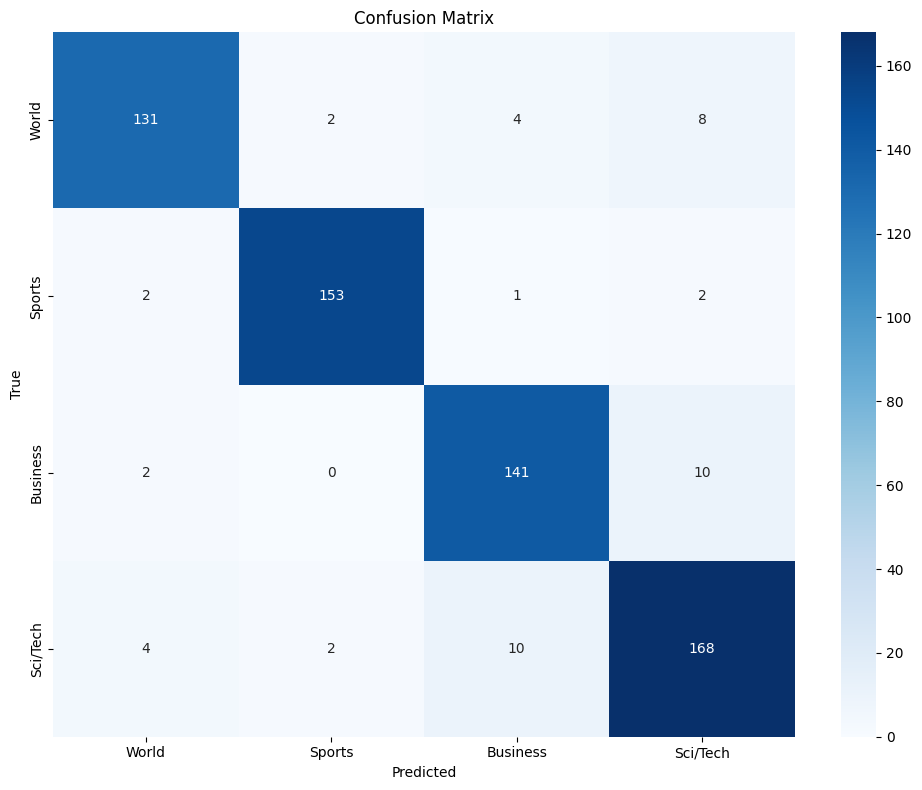

Evaluation Metrics:
Accuracy: 0.9266
Precision: 0.9271
Recall: 0.9266
F1 Score: 0.9267


In [21]:
# Check evaluation accuracy on validation set
eval_metrics, _ = evaluate_model(peft_model, eval_dataset, True, 32, data_collator)


In [22]:
# Process unlabelled test data
try:
    print("\nProcessing unlabelled test data...")
    unlabelled_dataset = pd.read_pickle("/content/drive/MyDrive/Roberta_lora/test_unlabelled.pkl")

    # For unlabelled dataset, check its structure
    print(f"Unlabelled dataset keys: {unlabelled_dataset.column_names if hasattr(unlabelled_dataset, 'column_names') else 'N/A'}")

    # If it's a pandas DataFrame, convert to HF Dataset
    if isinstance(unlabelled_dataset, pd.DataFrame):
        print("Converting DataFrame to Dataset")
        unlabelled_dataset = Dataset.from_pandas(unlabelled_dataset)

    # Preprocess the test data the same way as training data
    test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
    print(f"Loaded {len(test_dataset)} unlabelled test samples")

    # Run inference and save predictions
    print("Running inference on test dataset...")
    preds = evaluate_model(peft_model, test_dataset, False, 32, data_collator)

    df_output = pd.DataFrame({
        'ID': range(len(preds)),
        'Label': preds.numpy()  # Convert to numpy for saving
    })

    # Save predictions to CSV for submission
    submission_path = os.path.join(output_dir, "inference_output.csv")
    df_output.to_csv(submission_path, index=False)
    print(f"Inference complete. Predictions saved to {submission_path}")

    # Check the first few predictions
    print("\nSample predictions:")
    for i in range(min(5, len(df_output))):
        pred_class = df_output['Label'][i]
        print(f"Sample {i}: Predicted class: {pred_class} ({id2label[pred_class]})")

except Exception as e:
    print(f"Error processing unlabelled test data: {e}")
    print("Skipping test data processing - you'll need to rerun this section when you have the test data.")



Processing unlabelled test data...
Unlabelled dataset keys: ['text']


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Loaded 8000 unlabelled test samples
Running inference on test dataset...


100%|██████████| 250/250 [00:06<00:00, 37.74it/s]

Inference complete. Predictions saved to results_1/inference_output.csv

Sample predictions:
Sample 0: Predicted class: 3 (Sci/Tech)
Sample 1: Predicted class: 0 (World)
Sample 2: Predicted class: 0 (World)
Sample 3: Predicted class: 3 (Sci/Tech)
Sample 4: Predicted class: 1 (Sports)


In [23]:
# Final parameter check
final_trainable_params, final_all_params = Calculate_training_parameters(peft_model)
print("\nFinal Model Parameters:")
print(f"Training parameters: {training_params:,}")
print(f"All parameters: {all_params:,}")
print(f"Final accuracy: {eval_metrics['accuracy']:.4f}")


Final Model Parameters:
Training parameters: 667,396
All parameters: 125,316,104
Final accuracy: 0.9266


In [ ]:
import shutil
shutil.copytree("/content/results_1", "/content/drive/MyDrive/results_", dirs_exist_ok=True)

print("✅ outputs save MyDrive！")


